<a href="https://colab.research.google.com/github/kumiori/mec647/blob/main/2021_01_25_trial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import site
import sys


try : 
    from google.colab import files
except:
    pass
    
try:
    from fenics import *; from mshr import *
except ImportError as e:
    !apt-get install software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y fenics    
    site.addsitedir('/usr/lib/petsc/lib/python3/dist-packages')  # Always appends to end

    from fenics import *; from mshr import *
    from ufl import replace

!fenics-version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
software-properties-common is already the newest version (0.96.24.32.14).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]


In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [29]:
# Geometry

Lx = 1.; Ly = 2.
h = .3; a = .4 
crack_thick = 0.0005
cut_out_point_1 = (-a/2, -crack_thick/2)
cut_out_point_2 = (a/2, crack_thick/2)
mid_point = (0., 0.)
import math
theta = math.pi/180*45
cell_size = .1
nel = int(Ly/cell_size)


geom1 = Rectangle(Point(-Lx/2., -Ly/2), Point(Lx/2, Ly/2))
cut_out = Rectangle(Point(cut_out_point_1), Point(cut_out_point_2))
geom = geom1 - CSGRotation(cut_out, Point(mid_point), theta)
mesh = generate_mesh(geom, nel)
ndim = mesh.topology().dim()
#cell_mrk = MeshFunction('bool', mesh, ndim); cell_mrk.set_all(False)
#for cell in cells(mesh):
# distance = (mid_point[0] - cell.midpoint()[0], mid_point[1] - cell.midpoint()[1])
# d = sqrt((distance[0]**2) + (distance[1]**2))
# if d < 0.2:
#  cell_mrk[cell] = True
#meshFine = refine(mesh, cell_mrk)


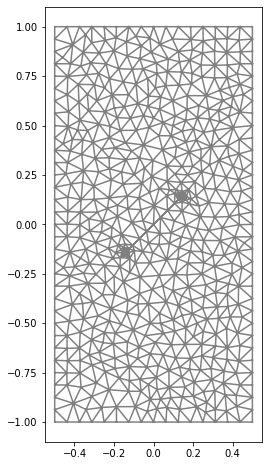

In [30]:
plt.figure(figsize=(10, 8))
plot(mesh)

In [31]:
ndim = mesh.topology().dim()

cell_mrk = MeshFunction('bool', mesh, ndim)
cell_mrk.set_all(False)

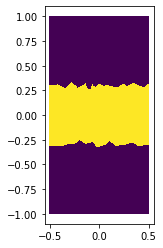

In [32]:
ref_threshold = 0.3

for cell in cells(mesh):
  if -ref_threshold < cell.midpoint()[1] < ref_threshold:
    cell_mrk[cell] = True

plot(cell_mrk)

for i in range(2): mesh = refine(mesh, cell_mrk)
# mesh = refine(mesh, cell_mrk)


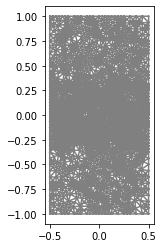

In [33]:
plot(mesh)

In [34]:
# Functional setting


V_u = VectorFunctionSpace(mesh, 'CG', 1)
V_alpha = FunctionSpace(mesh, 'CG', 1)

u = Function(V_u)
du = TrialFunction(V_u)
v = TestFunction(V_u)

alpha = Function(V_alpha)
beta = TestFunction(V_alpha)
dalpha = TrialFunction(V_alpha)


In [35]:
# Boundary conditions

ut = Expression('t', t=0., degree=0)

bcs_u = [DirichletBC(V_u.sub(1), ut, 'near(x[1], {}, 1e-5)'.format(Ly/2)), 
         DirichletBC(V_u.sub(1), Constant(0.), 'near(x[1], {}, 1e-5)'.format(-Ly/2))]



bca_0 = DirichletBC(V_alpha, Constant(0.), 'near(x[1], {}, 1e-5)'.format(Ly/2))
bca_1 = DirichletBC(V_alpha, Constant(0.), 'near(x[1], {}, 1e-5)'.format(-Ly/2))

bc_alpha = [bca_0, bca_1]

In [36]:
# Constitutive

# Constitutive functions

E, nu = Constant(1.), Constant(.0)
Gc = Constant(1.)
ell = Constant(0.05)

ndim = mesh.topology().dim()

def w(alpha):
  return alpha

def a(alpha):
  return (1-alpha)**2

def eps(u):
  return sym(grad(u))

def sigma0(u):
  mu = E/(2.*(1.+nu))
  lmbda = E*nu/(1-nu**2.)
  return 2*mu*eps(u) + lmbda*tr(eps(u))*Identity(ndim)

def sigma(alpha, u):
  return a(alpha)*sigma0(u)

In [37]:
import sympy

s = sympy.Symbol('s')
cw = float(sympy.integrate(4*sympy.sqrt(w(s)), (s, 0, 1)))


tmp = 2*(sympy.diff(w(s),s)/sympy.diff(1/a(s),s)).subs({"s":0})

print("Gc = %2.3f"%((ell*cw)/tmp))

Gc = Constant((ell*cw)/tmp)

Gc = 0.133


In [38]:
# Energetics


elastic_energy = 0.5*inner(sigma(alpha, u), eps(u))*dx
dissipated_energy = Gc/cw * (w(alpha)/ell + ell* inner(grad(alpha), grad(alpha)))*dx

total_energy = elastic_energy + dissipated_energy 

E_u = derivative(total_energy, u, v)

from ufl import replace
E_du = replace(E_u, {u: du})

E_alpha = derivative(total_energy, alpha, beta)
E_alpha_alpha = derivative(E_alpha,alpha, dalpha)



In [39]:
# Solve displacement problem, using automated derivative, and autmated 
# construction of linear and bilinear forms

# problem_u = LinearVariationalProblem()
problem_u = LinearVariationalProblem(lhs(E_du), rhs(E_du), u, bcs_u)
solver_u = LinearVariationalSolver(problem_u)
solver_u.parameters.update({"linear_solver" : "umfpack"})

# Alternatively, compute explicitly:

A = inner(sigma(alpha, du), eps(v))*dx
# f0, g0 exist in L^2(\Omega), L^2(\partial\Omega)
# L = dot(f0, v)*dx + dot(g0, v)*ds
zero = project(Constant((0., 0.)), V_u)
L = dot(zero, v)*dx

problem_u = LinearVariationalProblem(A, L, u, bcs_u)


In [40]:
# u = TrialFunction(V_u)
ut.t = 0.8
solver_u.solve()

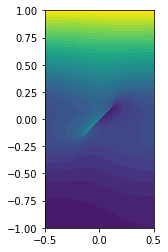

In [41]:
# dir(plot, mo)
plot(dot(u,u))

In [42]:
# Bounds

upperbound = project(Constant(1.), V_alpha)
lowerbound = project(Constant(0.), V_alpha)

# Boundary conditions
# set damage = 0 where we impose displacement boundary conditions

# bc_a1 = DirichletBC(V_alpha, Constant(0.), left)
# bc_a2 = DirichletBC(V_alpha, Constant(0.), right)

# bc_a = [bc_a1, bc_a2]

# Nonlinear problem and solver

problem_alpha = NonlinearVariationalProblem(E_alpha, alpha, bc_alpha, J=E_alpha_alpha)
problem_alpha.set_bounds(lowerbound, upperbound)

# solver able to solve with bounds: SNES

solver_alpha = NonlinearVariationalSolver(problem_alpha)
# info(solver_alpha.parameters, True)

snes_solver_parameters_bounds = {"nonlinear_solver": "snes", 
                                 "snes_solver": {"maximum_iterations": 300,
                                                 "absolute_tolerance": 1e-10,
                                                 "relative_tolerance": 1e-5,
                                                 "solution_tolerance": 1e-5,
                                                 "report": True,
                                                 "linear_solver" : "mumps"
                                                 }
                                }


# Solver method  |  Description                                                 
# ------------------------------------------------------------------------------
# bicgstab       |  Biconjugate gradient stabilized method                      
# cg             |  Conjugate gradient method                                   
# default        |  default linear solver                                       
# gmres          |  Generalized minimal residual method                         
# minres         |  Minimal residual method                                     
# mumps          |  MUMPS (MUltifrontal Massively Parallel Sparse direct Solver)
# petsc          |  PETSc built in LU solver                                    
# richardson     |  Richardson method                                           
# superlu        |  SuperLU                                                     
# tfqmr          |  Transpose-free quasi-minimal residual method                
# umfpack        |  UMFPACK (Unsymmetric MultiFrontal sparse LU factorization)  

solver_alpha.parameters.update(snes_solver_parameters_bounds)

solver_alpha.solve()




(18, True)

In [43]:
# boundaries
top = CompiledSubDomain("near(x[1], {}, 1e-4)".format(Ly/2.))
bottom = CompiledSubDomain("near(x[1], {}, 1e-4)".format(-Ly/2.))

#right = CompiledSubDomain("near(x[0], {}, 1e-4)".format(Lx/2.))
right = CompiledSubDomain("near(x[0], {}, 1e-4)".format(Lx/2.))

boundaries = MeshFunction("size_t", mesh, 1)
boundaries.set_all(0)
top.mark(boundaries, 1) # mark top as 1
bottom.mark(boundaries, 2) # mark bottom as 2
right.mark(boundaries, 3) # mark right as 3
ds = Measure("ds",subdomain_data=boundaries) # top: ds(1), bottom: ds(2), right



In [44]:

def alternate_minimisation(alpha, u,
                           alpha_0 = project(Constant(0.), V_alpha),
                           tol=1e-5, maxiter=100):
  alpha_diff = Function(V_alpha)
  iter = 1; error = 1
  alpha.vector()[:] = alpha_0.vector()
  
  while iter < maxiter and error > tol:
    solver_u.solve()
    # u: solution

    solver_alpha.solve()
    # alpha: solution
    # alpha0: alpha at previous timestep

    alpha_diff.vector()[:] = alpha.vector() - alpha_0.vector()
    error = norm(alpha_diff.vector(), 'l2')
    print("Iteration %d, error %e, alpha_max=%.3f"%(iter, error, max(alpha.vector())))
    alpha_0.assign(alpha)

    iter = iter+1

  return (iter, error)

In [45]:
alpha = Function(V_alpha)
ut.t = 1.8
alternate_minimisation(alpha, u)

Iteration 1, error 0.000000e+00, alpha_max=0.000


(2, 0.0)

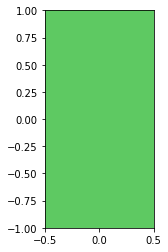

In [46]:
plot(alpha)

In [22]:
def postprocess():
    tot_en.append(assemble(total_energy))
    sur_en.append(assemble(dissipated_energy))
    ela_en.append(assemble(elastic_energy))
    # assemble(sigma(alpha, u)[1,1]*ds(1))
    react_top.append(assemble(sigma(alpha,u)[1,1]*ds(1)))
    print("** elastic = {:.3f}, surface = {:.3f}, total = {:.3f}"
      .format(ela_en[-1], sur_en[-1], tot_en[-1]))
    print("** Converged in {:d} iterations, error = {:.3f}"
      .format(iter, error))


In [23]:
import os
import shutil

savedir = "results/plate"
if os.path.isdir(savedir):
    shutil.rmtree(savedir)
    
file_alpha = File(savedir+"/alpha.pvd") 
file_u = File(savedir+"/u.pvd")

In [24]:
file_u << u

In [28]:
# Evolution monotonically increasing load

loads = np.linspace(0.5, 2.5, 30)

energies = []

tot_en = []
sur_en = []
ela_en = []
react_top = []

for (i, t) in enumerate(loads):
  ut.t = t
  print('')
  print("** Load step: t=%.2f"%t)
  (iter, error) = alternate_minimisation(alpha, u, alpha_0 = project(Constant(0.), V_alpha),
                           tol=1e-5, maxiter=100)
  lowerbound.vector()[:] = alpha.vector()
  # postproc
  postprocess()


energies = {'elastic': ela_en, 'surface': sur_en, 'total': tot_en}




** Load step: t=0.50
Iteration 1, error 0.000000e+00, alpha_max=0.000
** elastic = 0.062, surface = 0.000, total = 0.062
** Converged in 2 iterations, error = 0.000

** Load step: t=0.57
Iteration 1, error 0.000000e+00, alpha_max=0.000
** elastic = 0.080, surface = 0.000, total = 0.080
** Converged in 2 iterations, error = 0.000

** Load step: t=0.64
Iteration 1, error 0.000000e+00, alpha_max=0.000
** elastic = 0.100, surface = 0.000, total = 0.100
** Converged in 2 iterations, error = 0.000

** Load step: t=0.71
Iteration 1, error 0.000000e+00, alpha_max=0.000
** elastic = 0.123, surface = 0.000, total = 0.123
** Converged in 2 iterations, error = 0.000

** Load step: t=0.78
Iteration 1, error 0.000000e+00, alpha_max=0.000
** elastic = 0.148, surface = 0.000, total = 0.148
** Converged in 2 iterations, error = 0.000

** Load step: t=0.84
Iteration 1, error 0.000000e+00, alpha_max=0.000
** elastic = 0.176, surface = 0.000, total = 0.176
** Converged in 2 iterations, error = 0.000

** 

In [ ]:
plt.figure(figsize=(10, 8))
plot(alpha)

In [ ]:
def plot_stress():
    plt.plot(loads, react_top, 'b*', linewidth = 2)
    plt.xlabel('Displacement')
    plt.ylabel('Force')

def plot_energy():
    p1, = plt.plot(loads, energies['elastic'],'b*',linewidth=2)
    p2, = plt.plot(loads, energies['surface'],'r^',linewidth=2)
    p3, = plt.plot(loads, energies['total'],'ko',linewidth=2)
    plt.legend([p1, p2, p3], ["Elastic","Dissipated","Total"])
    plt.xlabel('Displacement')
    plt.ylabel('Energies')


def plot_energy_stress():
    plt.subplot(211)
    plot_stress()
    plt.subplot(212)
    plot_energy()
    plt.savefig('./energies_force.png')
    plt.show()

plot_energy_stress()